# Pearson correlation

In [ ]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

In this example we will estimate the population Pearson’s correlation
$\rho$. Although we could specify the full bivariate normal model as is
the case if we want to estimate correlations in JAGS and similar, we do
not have to. Instead, we will focus only on the parameter of interest,
the correlation coefficient $\rho$, and completely circumvent the
necessity of estimating the means and variances of the two variables.
Conceptually, our model is

where $\text{cor}$ is just a function that takes a $n \times 2$ matrix
and returns the Pearson’s product moment correlation coefficient of the
two columns.

Here, the parameter of interest is $\rho$, and the data is summarised by
$r$ and $n$. Therefore our inference will be invariant to the location
and scaling of the variables by construction.

### Simulator

Note that because the data is summarised by the pair $r$ and $n$, we can
also vary $n$ so that the model can make inferences on data from
different sample sizes. We achieve this by specifying a `context` that
will vary $n$ for each simulation. Here we vary $n$ between 3 and 100.

In [2]:
def context():
    return dict(n=np.random.randint(3, 101))

def prior():
    return dict(rho=np.random.uniform(low=-1, high=1))

def likelihood(n, rho):
    y = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]], size = n)
    r = np.corrcoef(y[:,0], y[:,1])[0,1]
    return dict(r=r)

simulator = bf.make_simulator([context, prior, likelihood])

### Approximator

In [ ]:
adapter=(
    bf.Adapter()
    .constrain("rho", lower=-1, upper=1)
    .rename("rho", "inference_variables")
    .concatenate(["n", "r"], into="inference_conditions")
)

In [ ]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=20, batch_size=256)

### Validation

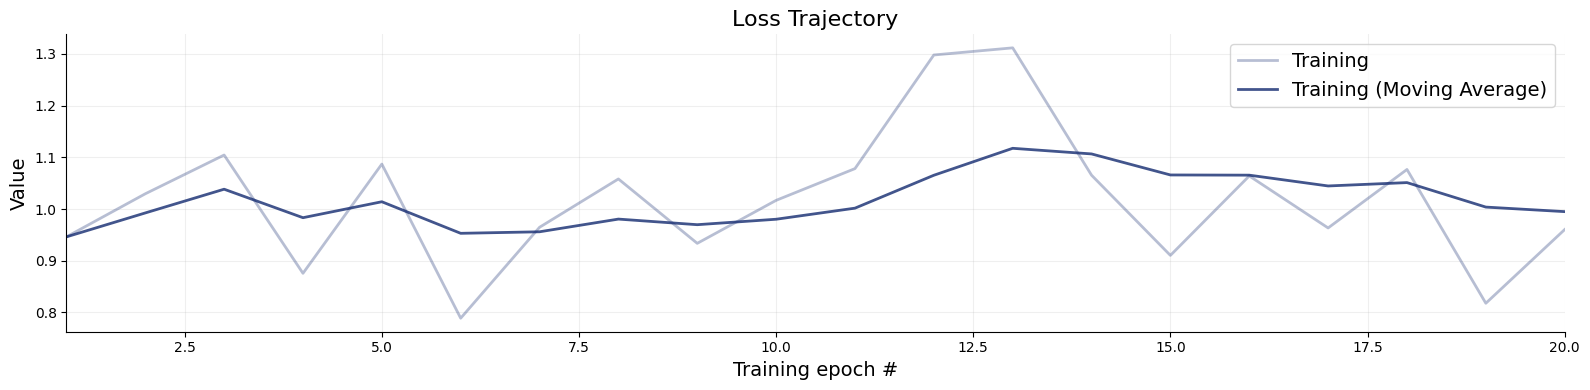

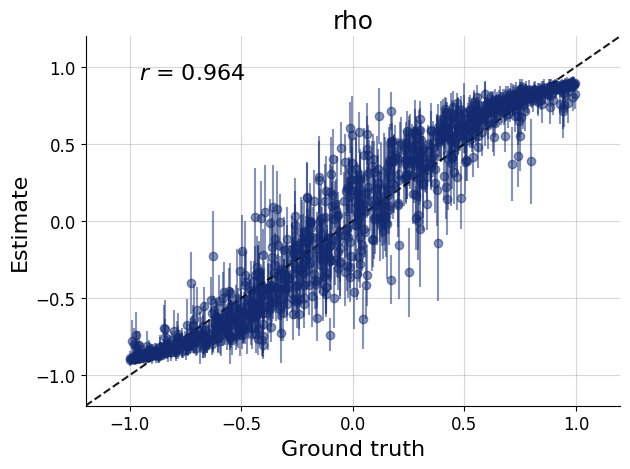

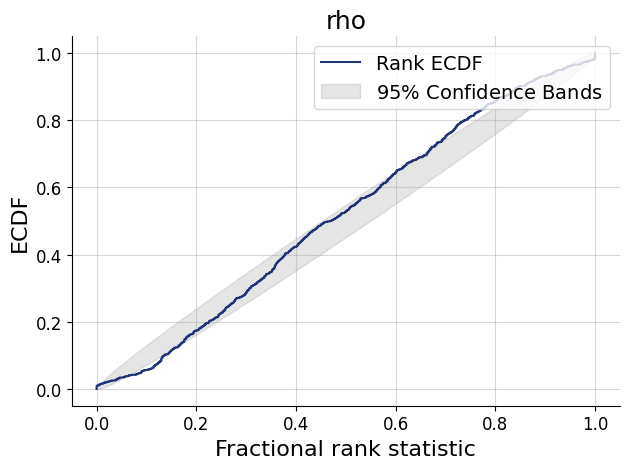

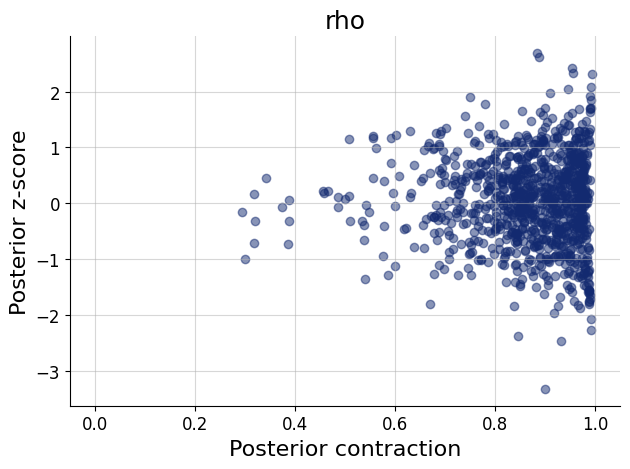

In [10]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Now we can estimate the parameter $\rho$ from data. We are provided two
synthetic data sets (Lee & Wagenmakers, 2013), both of which result with
the same Pearson correlation, but with a different sample size.

The advantage of BayesFlow is that once we have trained the networks we
can very easily apply them to multiple data sets at the same time -
simply pass them to the amortizer in an array.

In [11]:
# summary statistics of data set 1: r = -0.8109671, n = 11
# summary statistics of data set 2: r = -0.8109671, n = 22
inference_data = dict(
    n = np.array([[11], [22]]),
    r = np.array([[-0.8109671], [-0.8109671]]))

In [12]:
samples = workflow.sample(num_samples=2000, conditions=inference_data)

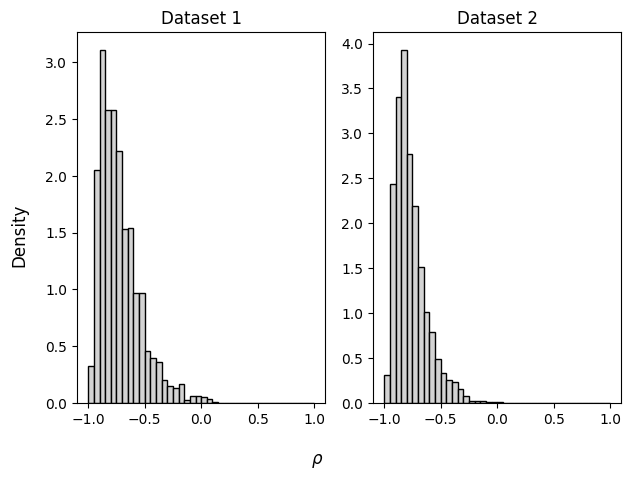

In [34]:
fig, axs = plt.subplots(ncols=2)

for i, ax in enumerate(axs):
    ax.set_title("Dataset " + str(i + 1))
    ax.hist(samples["rho"][i], 
            density=True, color="lightgray", edgecolor="black", bins=np.arange(-1, 1.05, 0.05))

fig.supxlabel(r"$\rho$")
fig.supylabel("Density")
fig.tight_layout()

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.